In [1]:
import numpy as np
np.version.version

'1.26.4'

In [1]:
import numpy as np
import os
import pickle
from pathlib import Path
import requests
import string
import re
from datasets import load_dataset

def decode(l):
    return ''.join([itos[i] for i in l])


# NLTK function to generate ngrams
import nltk
from nltk.util import ngrams
from nltk.probability import FreqDist

# HELPER FUNCTIONS

In [61]:
def get_entropy_split(words): 
    freq_dict = FreqDist(word.lower() for word in words)
    freq = np.array(list(freq_dict.values()))
    p = freq/sum(freq)
    entropy = np.sum(np.multiply(p*-1, np.log2(p))) 
    return entropy
    
#     freq_array = np.zeros(len(unique_words))
#     for i in range(0, len(unique_words)):
#         if i % 1000 == 0:
#             print(i)
#         word = unique_words[i]
#         freq_array[i] = words.count(word)
#     p = freq_array/len(unique_words)
#     entropy = np.sum(np.multiply(p*-1, np.log2(p))) 
#     return entropy

# SHAKESPEARE

In [66]:
with open("data/shakespeare/input.txt", 'r', encoding='utf-8') as f:
    data = f.read()

In [67]:
shakespeare = data.translate(str.maketrans("","", string.punctuation)).replace("\n", " ").lower()

In [9]:
# Pointwise Information Matrix 

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(data2))

[nltk_data] Downloading package punkt to /Users/jaylincl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
len(finder.score_ngrams(bigram_measures.pmi)) #check vocab size 
#this only bigram PMI, doesn't give us one for any words that don't occur next to each other 

106835

In [68]:
#VOCAB SIZE 
shakespeare_words = nltk.word_tokenize(shakespeare)
len(set(shakespeare_words))

12847

In [72]:
average_branching_factor(shakespeare, 2)

8.315949248851872

In [69]:
shakespeare_entropy = get_entropy(shakespeare)
shakespeare_entropy

9.729605221164615

# WikiText 

In [15]:
wiki = load_dataset("iohadrubin/wikitext-103-raw-v1", num_proc=8)

dataset_infos.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

Setting num_proc from 8 to 2 for the train split as it only contains 2 shards.


Generating train split:   0%|          | 0/29567 [00:00<?, ? examples/s]

Setting num_proc from 8 back to 1 for the validation split to disable multiprocessing as it only contains one shard.


Generating validation split:   0%|          | 0/60 [00:00<?, ? examples/s]

Setting num_proc from 8 back to 1 for the test split to disable multiprocessing as it only contains one shard.


Generating test split:   0%|          | 0/62 [00:00<?, ? examples/s]

In [135]:
def process_wiki(text_list):
    processed = ''

    for i in range(0, len(text_list)):
        doc = text_list[i]
        #remove title 
        without_title = re.sub(r'=[^\n]+\n', ' ', doc, count = 1)
        #remove foreign characters, numbers, punctuation, line breaks, and go to lowercase
        processed += re.sub(r'[^a-zA-z ]', ' ', without_title).translate(
            str.maketrans("","", string.punctuation)).replace(
            "\n", " ").lower()
        processed += " "
    return processed

In [131]:
wiki_train_processed = process_wiki(wiki['train']['text'])
wiki_val_processed = process_wiki(wiki['validation']['text'])
wiki_test_processed = process_wiki(wiki['test']['text'])

In [136]:
wiki_processed = wiki_train_processed + wiki_val_processed + wiki_test_processed

In [137]:
wiki_words = nltk.word_tokenize(wiki_processed)
len(set(wiki_words))

471951

In [151]:
wiki_entropy = get_entropy_split(wiki_words)
wiki_entropy

10.99309750946845

In [20]:
def process_wiki_doc(text_list):
    processed_list = [None] * len(text_list)

    for i in range(0, len(text_list)):
        doc = text_list[i]
        #remove title 
        without_title = re.sub(r'=[^\n]+\n', ' ', doc, count = 1)
        #remove foreign characters, numbers, punctuation, line breaks, and go to lowercase
        processed_list[i] =  re.sub(r'[^a-zA-z ]', ' ', without_title).translate(
            str.maketrans("","", string.punctuation)).replace(
            "\n", " ").lower()
    return processed_list

In [114]:
def avg_branching_factor(text, prev_word_dic={}, find_count=False):
    words = nltk.word_tokenize(text)
    word_dic = prev_word_dic
    for i,word in enumerate(words):
        if len(words) == i+1:
            continue
        if word_dic.get(word) == None:
            word_dic[word] = set([words[i+1]])
        else:
            w_set = word_dic[word]
            w_set.add(words[i+1])
    count = 0
    if find_count: 
        for k,v in word_dic.items():
            count += len(v)
        return count/len(word_dic)
    return word_dic

In [22]:
wiki_processed_doc_train = process_wiki_doc(wiki['train']['text'])
wiki_processed_doc_validation = process_wiki_doc(wiki['validation']['text'])
wiki_processed_doc_test = process_wiki_doc(wiki['test']['text'])

In [23]:
wiki_processed_doc = wiki_processed_doc_train + wiki_processed_doc_validation + wiki_processed_doc_test

In [117]:
for i in range(0, len(wiki_processed_doc)): 
    if i == 0:
        prev_dic = avg_branching_factor(wiki_processed_doc[i], prev_word_dic = {})
    elif i < len(wiki_processed_doc) - 1:
        prev_dic_temp = avg_branching_factor(wiki_processed_doc[i], prev_word_dic = prev_dic)
        prev_dic = prev_dic_temp
    else:
        final_dic2 = avg_branching_factor(wiki_processed_doc[i], prev_word_dic = prev_dic)

In [99]:
count = 0
for k,v in final_dic2.items():
    count += len(v)
result_wiki = count/len(final_dic2)
result_wiki

26.741648895352043

In [118]:
len(final_dic2.items()) 

471734

In [138]:
#figure out which words are missing

mykeys = final_dic2.keys()
mywords = set(wiki_words)

missing_words = list()

for word in mywords:
    if word not in final_dic:
        missing_words.append(word)

In [139]:
len(missing_words) #should be 961067 - 471734
#these are the words that are at the end of the documents and don't show up anywhere else 

217

## ENRON 

In [2]:
enron = load_dataset("snoop2head/enron_aeslc_emails", num_proc=8)

In [189]:
def process_enron(text_list):
    processed = ''

    for i in range(0, len(text_list)):
        doc = text_list[i]
        #remove title 
        body = doc.partition("Body:")[2]
        #remove foreign characters, numbers, punctuation, line breaks, and go to lowercase
        processed += re.sub(r'[^a-zA-z ]', '', body).translate(
            str.maketrans("","", string.punctuation)).replace(
            "\n", " ").lower()
    return processed

In [186]:
def process_enron_doc(text_list):
    processed_list = [None] * len(text_list)

    for i in range(0, len(text_list)):
        doc = text_list[i]
        #remove title 
        body = doc.partition("Body:")[2]
        #remove foreign characters, numbers, punctuation, line breaks, and go to lowercase
        processed_list[i] = re.sub(r'[^a-zA-z ]', '', body).translate(
            str.maketrans("","", string.punctuation)).replace(
            "\n", " ").lower()
    return processed_list

In [4]:
delimiter = " "
enron_string = delimiter.join(enron["train"]["text"])

In [9]:
def process_enron2(text_list):
    processed = ''

    for i in range(0, len(text_list)):
        doc = text_list[i]
        #remove title 
        body = doc.partition("Body:")[2]
        #remove foreign characters, numbers, punctuation, line breaks, and go to lowercase
        processed += re.sub(r'[^a-zA-z ]', ' ', body).translate(
            str.maketrans("","", string.punctuation)).replace(
            "\n", " ").lower()
    return processed

In [10]:
enron_processed2 = process_enron2(enron["train"]["text"])

In [11]:
enron_processed2[0:1000]

'  here is our forecast    traveling to have a business meeting takes the fun out of the trip   especially if you have to prepare a presentation   i would suggest holding the business plan meetings here then take a trip without any formal business meetings   i would even try and get some honest opinions on whether a trip is even desired or necessary  as far as the business meetings  i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not   too often the presenter speaks and the others are quiet just waiting for their turn    the meetings might be better if held in a round table discussion format    my suggestion for where to go is austin   play golf and rent a ski boat and jet ski s   flying somewhere takes too much time   test successful   way to go     randy   can you send me a schedule of the salary and level of everyone in the  scheduling group   plus your thoughts on any changes that need to be made    

In [13]:
enron_words2 = nltk.word_tokenize(enron_processed2)
enron_unique2 = set(enron_words2)
len(enron_unique2)

597200

In [62]:
enron_entropy = get_entropy_split(enron_words2)
enron_entropy

10.96357680299977

In [30]:
enron_freq_dict = FreqDist(word.lower() for word in enron_words2)

In [59]:
len(list(enron_freq_dict.values())) #exactly right 

597200

In [60]:
np.array(list(enron_freq_dict.values()))[0:10]

array([ 113969, 1243849,  303174,    8021,    3369, 4106550,  713633,
       2165311,  151436,  115060])

(array([23832.,  2822.,  1302.,   799.,   498.,   378.,   282.,   206.,
          215.,   177.]),
 array([  100.,  1090.,  2080.,  3070.,  4060.,  5050.,  6040.,  7030.,
         8020.,  9010., 10000.]),
 <BarContainer object of 10 artists>)

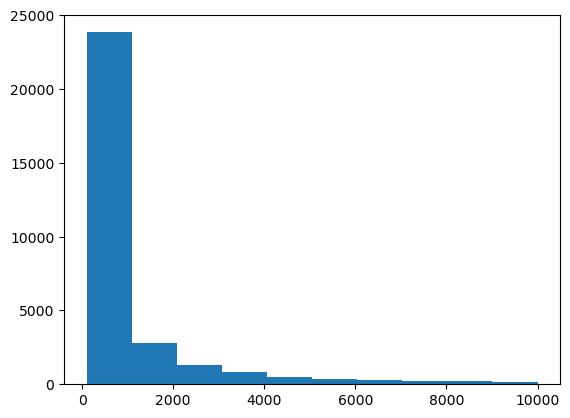

In [54]:
import matplotlib.pyplot as plt
plt.hist(np.array(list(enron_freq_dict.values())), range = (100, 10000))

In [57]:
#find words with highest frequency 
import heapq

heapq.nlargest(10, enron_freq_dict, key=enron_freq_dict.get)

['the', 'to', 'enron', 'and', 'com', 'of', 'a', 'in', 'for', 'on']

# OLD STUFF

In [ ]:
#need to rerun average branching factor 

In [190]:
enron_processed = process_enron(enron["train"]["text"])

In [193]:
enron_processed[0:1000]

' here is our forecast  traveling to have a business meeting takes the fun out of the trip  especially if you have to prepare a presentation  i would suggest holding the business plan meetings here then take a trip without any formal business meetings  i would even try and get some honest opinions on whether a trip is even desired or necessaryas far as the business meetings i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not  too often the presenter speaks and the others are quiet just waiting for their turn   the meetings might be better if held in a round table discussion format  my suggestion for where to go is austin  play golf and rent a ski boat and jet skis  flying somewhere takes too much time test successful  way to go randy can you send me a schedule of the salary and level of everyone in the scheduling group  plus your thoughts on any changes that need to be made  patti s for examplephillip le

In [191]:
enron_words = nltk.word_tokenize(enron_processed)
len(set(enron_words))

1619263

In [197]:
len(set(enron_words[0:100]))

67

In [ ]:
#RUN OVERNIGHT
enron_abf = average_branching_factor_split(enron_processed, 2)
enron_abf

In [70]:
enron_entropy = get_entropy_split(enron_words)
enron_entropy

409.1528585819451

In [187]:
enron_processed_doc = process_enron_doc(enron['train']['text'])

In [188]:
for i in range(0, len(enron_processed_doc)): 
    if i == 0:
        prev_dic = avg_branching_factor(enron_processed_doc[i])
    elif i < len(wiki_processed_doc) - 1:
        prev_dic = avg_branching_factor(enron_processed_doc[i], prev_word_dic = prev_dic)
    else:
        result_enron = avg_branching_factor(enron_processed_doc[i], prev_word_dic = prev_dic, find_count = True)
result_enron

8.811039325233148

In [ ]:
# SPACE CELL

In [74]:
wiki_words[0:100]

['senj',
 'no',
 'valkyria',
 'unrecorded',
 'chronicles',
 'japanese',
 'lit',
 'valkyria',
 'of',
 'the',
 'battlefield',
 'commonly',
 'referred',
 'to',
 'as',
 'valkyria',
 'chronicles',
 'iii',
 'outside',
 'japan',
 'is',
 'a',
 'tactical',
 'roleplaying',
 'video',
 'game',
 'developed',
 'by',
 'sega',
 'and',
 'mediavision',
 'for',
 'the',
 'playstation',
 'portable',
 'released',
 'in',
 'january',
 'in',
 'japan',
 'it',
 'is',
 'the',
 'third',
 'game',
 'in',
 'the',
 'valkyria',
 'series',
 'employing',
 'the',
 'same',
 'fusion',
 'of',
 'tactical',
 'and',
 'realtime',
 'gameplay',
 'as',
 'its',
 'predecessors',
 'the',
 'story',
 'runs',
 'parallel',
 'to',
 'the',
 'first',
 'game',
 'and',
 'follows',
 'the',
 'nameless',
 'a',
 'penal',
 'military',
 'unit',
 'serving',
 'the',
 'nation',
 'of',
 'gallia',
 'during',
 'the',
 'second',
 'europan',
 'war',
 'who',
 'perform',
 'secret',
 'black',
 'operations',
 'and',
 'are',
 'pitted',
 'against',
 'the',
 'impe

In [139]:
def average_branching_factor2(words):
    #create a dictionary of words where keys are sets of words that follow them 
    
    for i in range(0, len(words)-1): 
        print(words[i])
        if words[i] in d:
            old_value = d[words[i]]
            if words[i+1] not in old_value:
                d[words[i]] = old_value.append(words[i+1])
        else:
            d[words[i]] = list(words[i+1])
    return d

In [142]:
wiki_words.index("valkyria")


2

In [140]:
average_branching_factor2(wiki_words[0:100])

senj
no
valkyria
unrecorded
chronicles
japanese
lit
valkyria
of
the
battlefield
commonly
referred
to
as
valkyria


TypeError: argument of type 'NoneType' is not iterable

In [138]:
test.add("test2")
t2 = list(test).append("test3")